# 03. 實作多層神經網路

## 目錄

- 使用手寫數字來進行分類
- 實作多層感知機 (MLP)

# 使用手寫數字來進行分類

## 讀取 MNIST 資料集

MNIST 資料集可以在這裡下載: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

檔案:
- train-images-idx3-ubyte.gz: 訓練集圖片
- train-labels-idx1-ubyte.gz: 訓練集標籤
- t10k-images-idx3-ubyte.gz: 測試集圖片
- t10k-labels-idx1-ubyte.gz: 測試集標籤

In [1]:
MNIST = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"
]

### 安裝 wget 套件

In [2]:
# 使用 '!' 來執行系統指令
!pip install wget

### 下載 MNIST 資料集

In [3]:
# 匯入 os 套件
import os

# 設置 MNIST 資料集位置
# mnist_dir = "/content/mnist"
mnist_dir = "resources/mnist"
os.makedirs(mnist_dir, exist_ok=True)

In [4]:
# 匯入 wget 套件
import wget

# 下載資料集
for filename in MNIST:
    wget.download(f"http://yann.lecun.com/exdb/mnist/{filename}", mnist_dir)

### 解開 MNIST 壓縮

In [5]:
# 匯入 gzip 套件
import gzip

for filename in MNIST:
    z = os.path.join(mnist_dir, filename)
    with gzip.GzipFile(z, mode="rb") as decompressed, open(z[:-3], 'wb') as outfile:
        outfile.write(decompressed.read())

### 讀取 MNIST 資料

In [6]:
# 匯入 os, struct, numpy 套件
import struct
import numpy as np

# 撰寫讀取 MNIST 資料集
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, "rb") as label_path:
        magic, n = struct.unpack('>II', label_path.read(8))
        labels = np.fromfile(label_path, dtype=np.uint8)

    with open(images_path, "rb") as image_path:
        magic, num, rows, cols = struct.unpack('>IIII', image_path.read(16))
        images = np.fromfile(image_path, dtype=np.uint8)
        images = images.reshape(len(labels), 28*28)
        images = ((images / 255.) - .5) * 2

    return images, labels

#### 訓練集

In [7]:
# 顯示訓練集
x_train, y_train = load_mnist(mnist_dir, kind="train")
print("Rows: %d, Columns: %d" % (x_train.shape[0], x_train.shape[1]))

Rows: 60000, Columns: 784


#### 測試集

In [8]:
# 顯示測試集
x_test, y_test = load_mnist(mnist_dir, kind="t10k")
print("Rows: %d, Columns: %d" % (x_train.shape[0], x_train.shape[1]))

Rows: 60000, Columns: 784


#### 顯示每個數字的第一張影像

[]

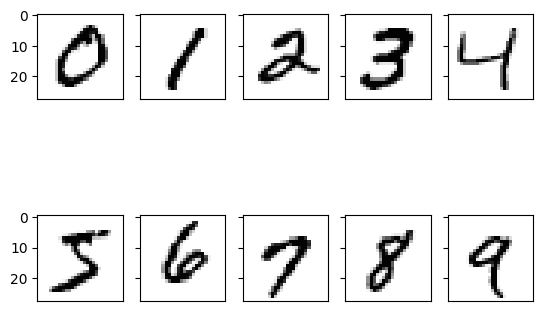

In [9]:
# 匯入 matplotlib 的畫布套件
import matplotlib.pyplot as plt

# 顯示 0~9 的手寫影像
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='all')
ax = ax.flatten()

for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])

#### 顯示 25 種不同版本的數字 7:

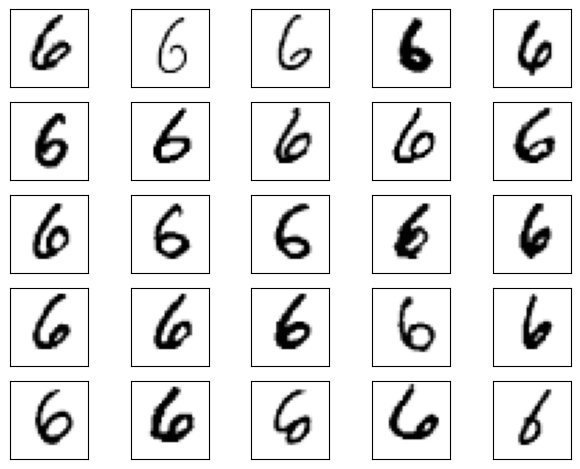

In [10]:
# 顯示多個版本的同樣數字的手寫影像
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(5 * 5):
    img = x_train[y_train == 6][i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

### 使用 Numpy 建立 MNIST 快取

In [11]:
# 快取儲存位置
output_dir = os.path.abspath("resources/mnist")
# output_dir = os.path.abspath("/content/mnist")
os.makedirs(output_dir, exist_ok=True)

# 建立快取
output_filepath = os.path.join(output_dir, "mnist_scaled.npz")
np.savez_compressed(
    output_filepath,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

#### 讀入 MNIST 快取

In [12]:
# 讀取快取
mnist = np.load(output_filepath)
mnist.files

['x_train', 'y_train', 'x_test', 'y_test']

In [13]:
# 讀取快取
x_train, y_train, x_test, y_test = [
    mnist[filename]
    for filename
    in ['x_train', 'y_train', 'x_test', 'y_test']
]
x_train.shape

(60000, 784)

# 實作多層感知機 (MLP)

In [14]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ 前向傳播神經網路 / 多層感知器分類器

    參數
    ------------
    n_hidden : int (default: 30)
        隱藏單元數量.
    l2 : float (default: 0.)
        L2 正規化的 lambda 值
        如果 l2=0. 不進行正規化 (default)
    epochs : int (default: 100)
        訓練集的傳遞次數。 (回合數)
    eta : float (default: 0.001)
        學習綠.
    shuffle : bool (default: True)
        如果為 True，則在每個 Epoch 對訓練資料進行洗牌以防止循環。
    minibatch_size : int (default: 1)
        每個小批量的訓練樣本數。
    seed : int (default: None)
        用於初始化權重和洗牌的隨機種子。

    屬性
    -----------
    eval_ : dict
      收集訓練期間每個 EPOCH 的 cost、訓練正確率和驗證正確率。

    """
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):
        self._random = np.random.RandomState(seed)
        self._n_hidden = n_hidden
        self._l2 = l2
        self.epochs = epochs
        self._eta = eta
        self._shuffle = shuffle
        self._minibatch_size = minibatch_size
        self.eval_ = None
        self._w_out = None
        self._b_out = None
        self._w_h = None
        self._b_h = None

    def _onehot(self, y, n_classes):
        """編碼標籤為 one-hot 表達式

        參數
        ------------
        y : array, shape = [n_examples]
            目標值. (label)
        n_classes : int
            類別數量

        回傳
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, _z):
        """計算邏輯函數（sigmoid）"""
        return 1. / (1. + np.exp(-np.clip(_z, -250, 250)))

    def _forward(self, _x):
        """計算前向傳播"""

        # 第一步: 計算隱藏層的網路
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(_x, self._w_h) + self._b_h

        # 第二步: 活化隱藏層
        a_h = self._sigmoid(z_h)

        # 第三步: 計算輸出層的網路
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]
        z_out = np.dot(a_h, self._w_out) + self._b_out

        # step 4: 活化輸出層
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """計算成本函數

        參數
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot 編碼的類別標籤
        output : array, shape = [n_examples, n_output_units]
            活化輸出層 (前向傳遞)

        回傳
        ---------
        cost : float
            正規化成本

        """
        _l2_term = (self._l2 *
                   (np.sum(self._w_h ** 2.) +
                    np.sum(self._w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + _l2_term
                
        return cost

    def predict(self, _x):
        """預測類別標籤

        參數
        -----------
        _x : array, shape = [n_examples, n_features]
            輸入層的原始特徵

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            預設的類別標籤.

        """
        z_h, a_h, z_out, a_out = self._forward(_x)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, _x_train, _y_train, _x_valid, _y_valid):
        """ 從訓練資料學習權重

        參數
        -----------
        _x_train : array, shape = [n_examples, n_features]
            給輸入層的原始特徵
        _y_train : array, shape = [n_examples]
            目標類別標籤
        _x_valid : array, shape = [n_examples, n_features]
            訓練期間驗證的樣本特徵
        _y_valid : array, shape = [n_examples]
            訓練期間驗證的樣本標籤

        回傳
        ----------
        self

        """
        n_output = np.unique(_y_train).shape[0]  # 類別標籤數量
        n_features = _x_train.shape[1]  # 特徵數量

        ########################
        # 權重初始化
        ########################

        # 權重: 輸入層 -> 隱藏層
        self._b_h = np.zeros(self._n_hidden)
        self._w_h = self._random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self._n_hidden))

        # 權重: 隱藏層 -> 輸出層
        self._b_out = np.zeros(n_output)
        self._w_out = self._random.normal(loc=0.0, scale=0.1,
                                        size=(self._n_hidden, n_output))
        
        # 用於進度格式化
        epoch_strlen = len(str(self.epochs))  
        
        # 初始化評估值
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        # 將標籤進行 one-hot 編碼
        y_train_enc = self._onehot(_y_train, n_output)

        # 迭代 EPOCH
        for i in range(self.epochs):

            # 迭代小批量
            indices = np.arange(_x_train.shape[0]) # 訓練集 60000 的索引列表
            
            # 將訓練集打散
            if self._shuffle:
                self._random.shuffle(indices) 

            for start_idx in range(0, indices.shape[0] - self._minibatch_size +
                                   1, self._minibatch_size):
                batch_idx = indices[start_idx:start_idx + self._minibatch_size]

                # 前向傳播
                z_h, a_h, z_out, a_out = self._forward(_x_train[batch_idx])

                ##################
                # 反向傳播
                ##################

                # [n_examples, n_classlabels]
                # 計算輸出與標籤的差異量
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                # 進行 sigmoid 的微分計算
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                # 計算隱藏層權重的更新量
                delta_h = (np.dot(delta_out, self._w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                # 計算輸入層權重的更新量
                grad_w_h = np.dot(_x_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                # 計算輸出層權重的更新量
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # 正規化和權重更新
                delta_w_h = (grad_w_h + self._l2 * self._w_h)
                delta_b_h = grad_b_h # 偏權值不進行正規化
                self._w_h -= self._eta * delta_w_h
                self._b_h -= self._eta * delta_b_h

                delta_w_out = (grad_w_out + self._l2 * self._w_out)
                delta_b_out = grad_b_out  # 偏權值不進行正規化
                self._w_out -= self._eta * delta_w_out
                self._b_out -= self._eta * delta_b_out

            #############
            # 評估
            #############

            # 訓練期間每個 EPOCH 後的評估
            z_h, a_h, z_out, a_out = self._forward(_x_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(_x_train)
            y_valid_pred = self.predict(_x_valid)

            train_acc = ((np.sum(_y_train == y_train_pred)).astype(np.float32) /
                         _x_train.shape[0])
            valid_acc = ((np.sum(_y_valid == y_valid_pred)).astype(np.float32) /
                         _x_valid.shape[0])
            
            # 顯示當前的評估值
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

## 訓練多層感知機

In [15]:
n_epochs = 200

nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(_x_train=x_train[:55000], 
       _y_train=y_train[:55000],
       _x_valid=x_train[55000:],
       _y_valid=y_train[55000:])

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%  

## 繪製損失曲線

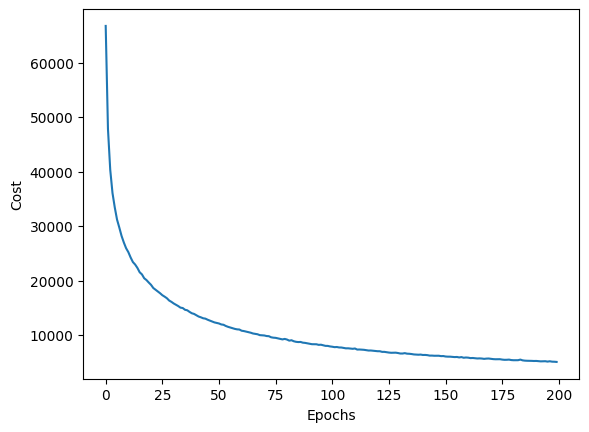

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')

plt.show()

## 繪製測試集與驗證集的正確率曲線

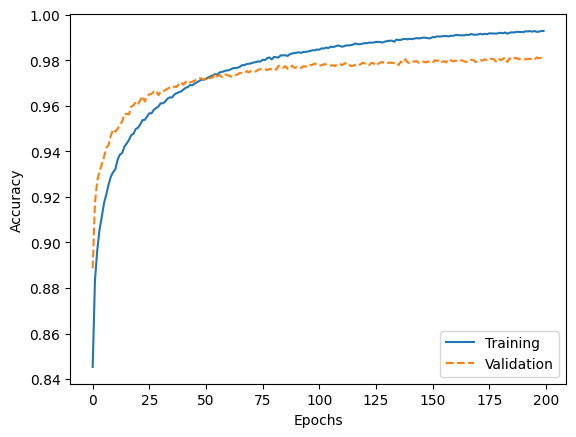

In [17]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.show()

## 使用測試集進行評估

In [18]:
y_test_pred = nn.predict(x_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float32) / x_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%


## 顯示一些預測結果

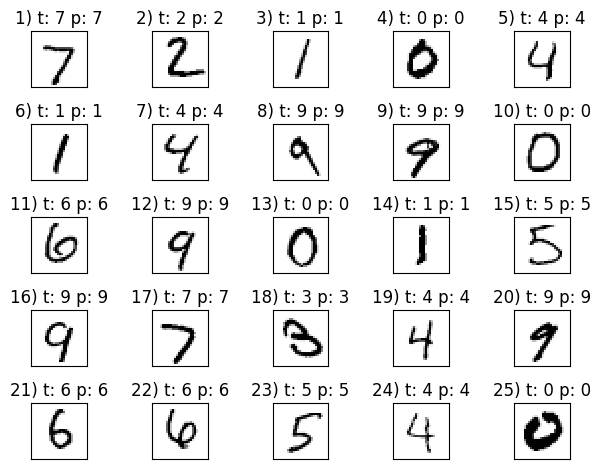

In [19]:
mnist_img = x_test[y_test == y_test_pred][:25]
correct_lab = y_test[y_test == y_test_pred][:25]
mnist_lab = y_test_pred[y_test == y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = mnist_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], mnist_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

plt.show()

## 顯示一些預測錯誤結果

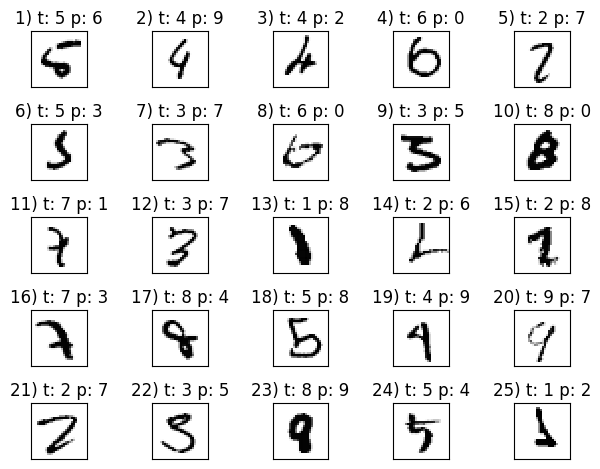

In [20]:
mnist_img = x_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
mnist_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
mnist_img = x_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
mnist_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = mnist_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], mnist_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

plt.show()for i in range(25):
    img = mnist_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], mnist_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

plt.show()